In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import pairwise_distances
from sklearn.mixture import GaussianMixture

In [12]:
class KMeans:
    def __init__(self, k, method='random', max_iter=50):
        self.k = k 
        self.method = method
        self.max_iter = max_iter

    def init_centers(self, X: np.ndarray):
        if self.method == 'random':
            return X[np.random.choice(X.shape[0], size=self.k, replace=False)]
        if self.method == 'k-means++':
            centroids = []
            ind = np.random.choice(X.shape[0])
            centroids.append(X[ind])
            for i in range(1, self.k):
                dist = pairwise_distances(X, centroids).min(axis=1)
                dist_sq = np.square(dist).flatten()
                ind = np.random.choice(X.shape[0], p=(dist_sq)/sum(dist_sq))
                centroids.append(X[ind])
            return np.array(centroids)

    def fit(self, X):
        self.score_min = None
        self.centroids_min = None
        for _ in range(10):
            self.centroids = self.init_centers(X)
            for _ in range(self.max_iter):
                clusters = self.expectation(X, self.centroids)
                new_centroids = self.maximization(X, clusters)
                if np.array_equal(new_centroids, self.centroids):
                    break
                self.centroids = new_centroids
            score = self.score(X)
            if self.score_min is None:
                self.score_min = score
                self.centroids_min = self.centroids
            else:
                if score < self.score_min:
                    self.score_min = score
                    self.centroids_min = self.centroids
        self.centroids = self.centroids_min

    def expectation(self, X, centroids):
        clusters = np.argmin(pairwise_distances(X, centroids), axis=1)
        return clusters

    def maximization(self, X, clusters):
        new_centroids = []
        for cluster in np.unique(clusters):
            cluster_X = X[clusters == cluster]
            new_centroids.append(cluster_X.mean(axis=0))
        new_centroids = np.array(new_centroids)
        return new_centroids
        
    def predict(self, X):
        y_pred = self.expectation(X, self.centroids)
        return y_pred
    
    def predict_proba(self, X):
        distances = pairwise_distances(X, self.centroids)
        mins = distances.min(axis=1); maxs = distances.max(axis=1)
        probas = (distances.T - (mins - 0.05)).T / ((maxs + 0.05) - (mins - 0.05)).reshape(-1,1)
        return probas
    
    def score(self, X):
        distances = pairwise_distances(X, self.centroids)
        return distances.min(axis=1).sum()


In [13]:
class GMM:
    def __init__(self,
                 n_clusters=10,
                 init_params='k-means',
                 tol=[None, None],
                 max_iter=100):
        self.n_clusters: int = n_clusters
        self.init_params: str = init_params
        self.tol: list = tol
        self.max_iter: int = max_iter
        
        self.mean: np.ndarray = None
        self.covariance: np.ndarray = None
        self.pi: np.ndarray = None
        self.gamma: np.ndarray = None
    
    def kmeans_init(self, X):
        kmeans = KMeans(k=3, method='k-means++')
        kmeans.fit(X)
        y_kmeans = kmeans.predict(X)

        self.mean = kmeans.centroids

        _, counts = np.unique(y_kmeans, return_counts=True)
        self.pi = counts/y_kmeans.shape[0]

        covariance = []
        for i in range(self.n_clusters):
            X_i = X[y_kmeans == i]
            covariance.append(np.cov(X_i.T))
        self.covariance = np.array(covariance)
                
    def init_centers(self, X):
        if self.init_params == 'k-means':
            self.kmeans_init(X)
        
    def pdf(self, X, mean, covariance):
        cov_mat_inv = np.linalg.inv(covariance)
        cov_mat_det = np.linalg.det(covariance)
        coef = (1/np.sqrt(2*np.pi*cov_mat_det))

        pdf_x = []
        for x in X:
            pdf_x.append(coef * np.exp((-1/2)*(x-mean).T.dot(cov_mat_inv).dot(x-mean)))
        pdf_x = np.array(pdf_x)
        return pdf_x
    
    def fit(self, X):
        if self.tol[0] is None:
            self.tol[0] = 1e-7
        if self.tol[1] is None:
            self.tol[1] = 1e-6
        self.init_centers(X)
        for _ in range(self.max_iter):
            self.expectation(X)
            mean = self.mean.copy()
            pi = self.pi.copy()
            self.maximization(X)
            if np.linalg.norm(self.mean-mean, axis=1).max() <= self.tol[0]:
                if np.max((pi - self.pi)) < self.tol[1]:
                    print('Tolerance limit reached')
                    break
        
    def expectation(self, X):
        gammas = []
        for i in range(self.n_clusters):
            gammas.append(self.pi[i]*self.pdf(X, self.mean[i], self.covariance[i]))
        gammas = np.array(gammas)
        self.gamma = (gammas/gammas.sum(axis=0)).T
        
    def maximization(self, X: np.ndarray):
        # new_mean: matrix of size of n_clusters x len(X[0]) 
        # new_covariance: tensor of size n_clusters x len(X[0]) x len(X[0])
        # new_pi: array of size of n_clusters
        
        N_k = np.sum(self.gamma, axis=0)
        
        for i in range(self.n_clusters):
            self.mean[i] = (1/N_k[i])*np.multiply(self.gamma[:,i].reshape(-1,1), X).sum(axis=0)

            cov_s = [self.gamma[j,i]*np.outer(X[j]-self.mean[i], X[j]-self.mean[i]) for j in range(X.shape[0])]
            cov_s = np.sum(cov_s, axis=0)
            self.covariance[i] = (1/N_k[i])*cov_s
            
            self.pi[i] = N_k[i]/X.shape[0]
        
    def fit_predict(self, X):
        return self.predict(self.fit(X))
    
    def predict_proba(self, X):
        return self.gamma
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

Tolerance limit reached


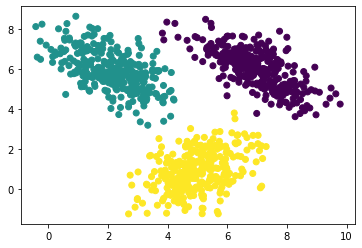

In [15]:
X_0 = np.random.multivariate_normal([2, 6], [[1.1, -0.7], [-0.7, 1.1]], 300)
X_1 = np.random.multivariate_normal([5, 1], [[1.1, 0.5], [0.5, 1.1]], 300)
X_2 = np.random.multivariate_normal([7, 6], [[1.1, -0.7], [-0.7, 1.1]], 300)
X = np.concatenate([X_0, X_1, X_2])

# plt.scatter(X_0[:,0], X_0[:,1])
# plt.scatter(X_1[:,0], X_1[:,1])
# plt.scatter(X_2[:,0], X_2[:,1])
# plt.show()

# X = pd.read_csv('data.csv').values[:,1:]


clf = GMM(n_clusters=3)

clf.fit(X)
y_pred = clf.predict(X)

plt.scatter(X[:,0], X[:,1], c=y_pred)
plt.show()